<a href="https://colab.research.google.com/github/DaiVo20/za_traffic_detection/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image, ImageDraw
from matplotlib import patches
import cv2
from google.colab.patches import cv2_imshow

# Prepare training dataset

In [ ]:
# Class descriptions:
idx2sign = {
    1: "No entry", # Cấm ngược chiều
    2: "No parking / waiting", # Cấm dừng và đỗ
    3: "No turning", # Cấm rẽ
    4: "Max Speed", # Giới hạn tốc độ
    5: "Other prohibition signs", # Cấm còn lại
    6: "Warning", # Nguy hiểm
    7: "Mandatory" # Hiệu lệnh
}

PATH = "drive/MyDrive/TrafficSign/data/za_traffic_2020"
TRAIN_PATH = os.path.join(PATH, "traffic_train")
json_path = os.path.join(TRAIN_PATH, "train_traffic_sign_dataset.json")
csv_path = os.path.join(TRAIN_PATH, "train.csv")

In [ ]:
sign2idx = {}
for k, v in idx2sign.items():
  sign2idx[v] = k

In [ ]:
sign2idx

{'Mandatory': 7,
 'Max Speed': 4,
 'No entry': 1,
 'No parking / waiting': 2,
 'No turning': 3,
 'Other prohibition signs': 5,
 'Warning': 6}

In [ ]:
with open(csv_path, "w") as csv_file:
  csv_file.write("file_name,xmin,ymin,xmax,ymax,class,label\n")
  with open(json_path) as json_file:
    data = json.load(json_file)
    annotations = data['annotations']
    for p in annotations:
      # print(p)
      # print('Bbox: ',p['bbox'])
      # print('Image: ',p['image_id'])
      # print('category_id: ',idx2sign[p['category_id']])
      csv_file.write("{}/{}.png,{},{},{},{},{},{}\n".format(os.path.join(TRAIN_PATH, "images"),p['image_id'], 
                                                         p['bbox'][0], p['bbox'][1],
                                                         p['bbox'][0]+p['bbox'][2], 
                                                         p['bbox'][1]+p['bbox'][3],
                                                         idx2sign[p['category_id']],
                                                         p['category_id']))

In [ ]:
df = pd.read_csv(csv_path)
df.head()

,file_name,xmin,ymin,xmax,ymax,class,label
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,880,333,899,351,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1069,355,1152,438,No turning,3
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,768,480,777,487,No parking / waiting,2
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,781,337,798,352,Warning,6
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,733,352,740,360,No parking / waiting,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  11000 non-null  object
 1   xmin       11000 non-null  int64 
 2   ymin       11000 non-null  int64 
 3   xmax       11000 non-null  int64 
 4   ymax       11000 non-null  int64 
 5   class      11000 non-null  object
 6   label      11000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 601.7+ KB


In [ ]:
df.file_name.nunique()

4500

In [ ]:
test_path = "/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_public_test/test.csv"
df2 = pd.read_csv(test_path)
df2.head()

,file_name,xmin,ymin,xmax,ymax,class,labels
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1133,284,1199,342,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,864,322,877,333,Max Speed,4
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1060,307,1110,348,No parking / waiting,2
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,805,294,829,318,No parking / waiting,2
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,732,290,745,302,No entry,1


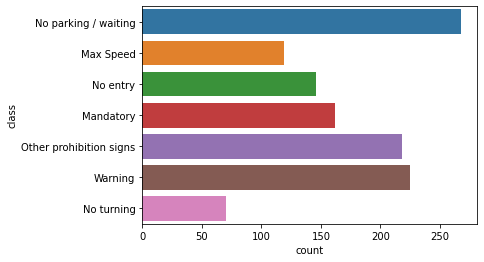

In [ ]:
sns.countplot(y=df2['class'])

# Visualize training dataset

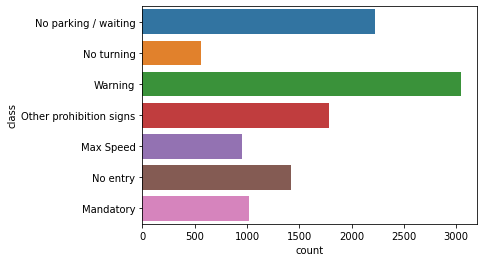

In [ ]:
sns.countplot(y=df['class'])

In [ ]:
def plot_image_examples(df, rows=2, cols=2, title='Image examples'):
  fig, axs = plt.subplots(rows, cols, figsize=(20,10))
  for row in range(rows):
    for col in range(cols):
      idx = np.random.randint(len(df), size=1)[0]
      img = Image.open(df.loc[idx, 'file_name'])
      axs[row, col].imshow(img)
      data = df[df['file_name']==df.loc[idx, 'file_name']]
      # print(data)
      for i in data.index:
        # print(i)
        # rect = cv2.rectangle(img, (df.loc[i,'xmin'], df.loc[i, 'ymin']), 
        #                      (df.loc[i,'xmax'], df.loc[i, 'ymax']),
        #                      color = (255, 0, 0), thickness = 2)

        rect = patches.Rectangle((df.loc[i,'xmin'], df.loc[i, 'ymin']), 
                                 df.loc[i, 'xmax']-df.loc[i, 'xmin'], 
                                 df.loc[i, 'ymax']-df.loc[i, 'ymin'],
                                 linewidth=1,edgecolor='r',facecolor='none')
        axs[row, col].add_patch(rect)
        axs[row, col].text(df.loc[i,'xmin'], df.loc[i, 'ymin'], df.loc[i, 'class'],
                           bbox={"alpha": 0.4},
                           clip_box=axs[row, col].clipbox, clip_on=True)

      axs[row, col].axis('off')

  plt.suptitle(title)

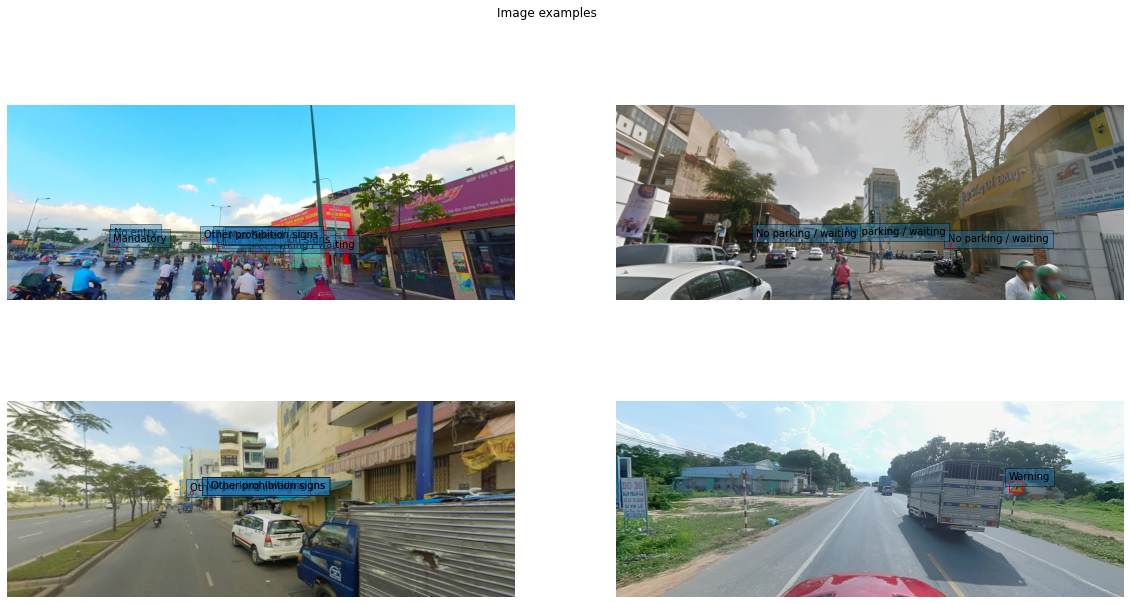

In [ ]:
plot_image_examples(df)

103 128 1036 1061
114 119 907 913
107 113 906 912
52 105 1145 1211


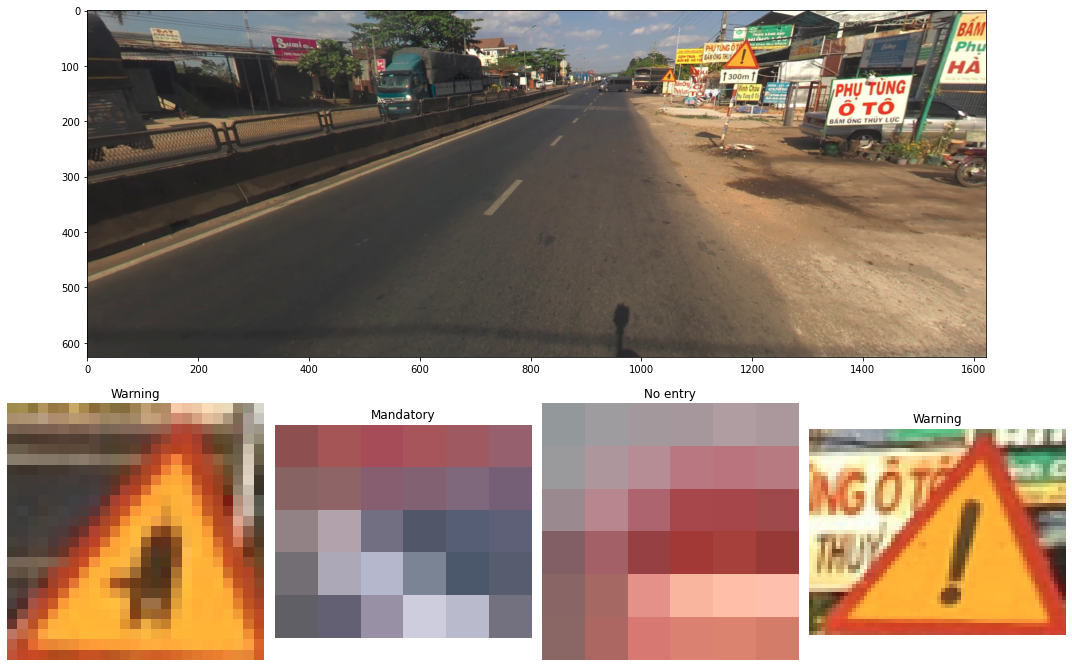

In [ ]:
idx = np.random.randint(len(df), size=1)[0]
img = Image.open(df.loc[idx, 'file_name'])
df_img = df.loc[df['file_name'] == df.loc[idx, 'file_name'],:]
df_img

n_label = len(df_img)
if n_label%4==0:
  rows = n_label//4
else:
  rows = n_label//4 + 1

fig = plt.figure(tight_layout=True, figsize=(15,10))
gs = gridspec.GridSpec(rows+1, 4)

ax = fig.add_subplot(gs[0, :])
ax.imshow(img)
# ax.axis("off")

r, c = 1, 0
for i in df_img.index:
  ax1 = fig.add_subplot(gs[r, c])
  ROI = img.crop((df.loc[i,'xmin'], df.loc[i,'ymin'], df.loc[i,'xmax'], df.loc[i,'ymax']))
  # ROI = image[2*df.loc[i,'ymin']-df.loc[i,'ymax']:df.loc[i,'ymin'], df.loc[i,'xmin']:df.loc[i,'xmax']]
  print(df.loc[i,'ymin'],df.loc[i,'ymax'], df.loc[i,'xmin'],df.loc[i,'xmax'])
  # ROI_cv = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
  ax1.set_title(df.loc[i,'class'])
  ax1.imshow(ROI)
  ax1.axis("off")
  # cv2.imwrite('data/ROI_{}.png'.format(ROI_number), ROI)
  c+=1
  if c > 3:
    c=0
    r+=1

# ROI_number = 0
# for c in df_img.index:
#     print(df.loc[c,'class'])
#     ROI = image[df.loc[c,'ymin']:df.loc[c,'ymax'], df.loc[c,'xmin']:df.loc[c,'xmax']]
#     plt.figure(figsize=(5,5))
#     plt.imshow(ROI)
#     plt.axis('off')
#     # cv2.imwrite('data/ROI_{}.png'.format(ROI_number), ROI)
#     cv2.rectangle(copy,(df.loc[c,'xmin'],df.loc[c,'ymin']),
#                   (df.loc[c,'xmax'],df.loc[c,'ymax']),(36,255,12),2)
#     ROI_number += 1

# **Data preprocessing**

## **Loại bỏ bounding box trùng nhau**

In [ ]:
#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]


def non_max_suppression_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/train.csv')

In [ ]:
df_train.head(20)

,file_name,xmin,ymin,xmax,ymax,class,label
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,880,333,899,351,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1069,355,1152,438,No turning,3
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,768,480,777,487,No parking / waiting,2
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,781,337,798,352,Warning,6
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,733,352,740,360,No parking / waiting,2
5,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1024,160,1099,232,No parking / waiting,2
6,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1138,295,1185,336,No parking / waiting,2
7,drive/MyDrive/TrafficSign/data/za_traffic_2020...,986,371,997,380,No turning,3
8,drive/MyDrive/TrafficSign/data/za_traffic_2020...,979,363,987,369,No parking / waiting,2
9,drive/MyDrive/TrafficSign/data/za_traffic_2020...,290,295,328,336,Other prohibition signs,5


In [ ]:
dict_ = {'file_name':[], 'xmin':[], 'ymin':[], 'xmax':[], 'ymax':[], 'label':[]}
for file_name in df_train['file_name'].unique():
    df = df_train[df_train['file_name'] == file_name]
    bbxs = []
    for c in df.index:
        bbxs.append((df.loc[c,'xmin'], df.loc[c,'ymin'], df.loc[c,'xmax'], df.loc[c,'ymax'], df.loc[c,'label']))
    pick = non_max_suppression_slow(np.array(bbxs), 0.7)

    for bbx_pick in pick:
        dict_['file_name'].append(file_name)
        dict_['xmin'].append(bbx_pick[0])
        dict_['ymin'].append(bbx_pick[1])
        dict_['xmax'].append(bbx_pick[2])
        dict_['ymax'].append(bbx_pick[3])
        dict_['label'].append(bbx_pick[4])

In [ ]:
df_filter = pd.DataFrame(dict_)

In [ ]:
df_filter

,file_name,xmin,ymin,xmax,ymax,class,label
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,880,333,899,351,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,768,480,777,487,No parking / waiting,2
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1069,355,1152,438,No turning,3
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,781,337,798,352,Warning,6
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,733,352,740,360,No parking / waiting,2
...,...,...,...,...,...,...,...
9071,drive/MyDrive/TrafficSign/data/za_traffic_2020...,902,290,1175,390,Mandatory,7
9072,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1338,173,1386,214,No parking / waiting,2
9073,drive/MyDrive/TrafficSign/data/za_traffic_2020...,969,335,984,351,Max Speed,4
9074,drive/MyDrive/TrafficSign/data/za_traffic_2020...,800,281,821,297,Warning,6


In [ ]:
df_filter['class'] = df_filter['label'].replace(idx2sign)

In [ ]:
df_filter = df_filter.reindex(columns=['file_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'label'])

In [ ]:
csv_path_filter = os.path.join(TRAIN_PATH, "train_filter.csv")
df_filter.to_csv(csv_path_filter, index=None)

## **Chia ảnh to thành các ảnh nhỏ có kích thước bằng nhau**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/train_filter.csv')
df.head()

,file_name,xmin,ymin,xmax,ymax,class,label
0,drive/MyDrive/TrafficSign/data/za_traffic_2020...,880,333,899,351,No parking / waiting,2
1,drive/MyDrive/TrafficSign/data/za_traffic_2020...,768,480,777,487,No parking / waiting,2
2,drive/MyDrive/TrafficSign/data/za_traffic_2020...,1069,355,1152,438,No turning,3
3,drive/MyDrive/TrafficSign/data/za_traffic_2020...,781,337,798,352,Warning,6
4,drive/MyDrive/TrafficSign/data/za_traffic_2020...,733,352,740,360,No parking / waiting,2


In [ ]:
df.shape

(9076, 7)

In [ ]:
df['area'] = (df['xmax']-df['xmin'])*(df['ymax']-df['ymin'])

In [ ]:
df['area'].describe()

count     9076.000000
mean      1105.981600
std       2710.154755
min          4.000000
25%         99.000000
50%        272.000000
75%        891.000000
max      54526.000000
Name: area, dtype: float64

In [ ]:
len(df['area'][df['area'] <=500]), len(df)

(5791, 9076)

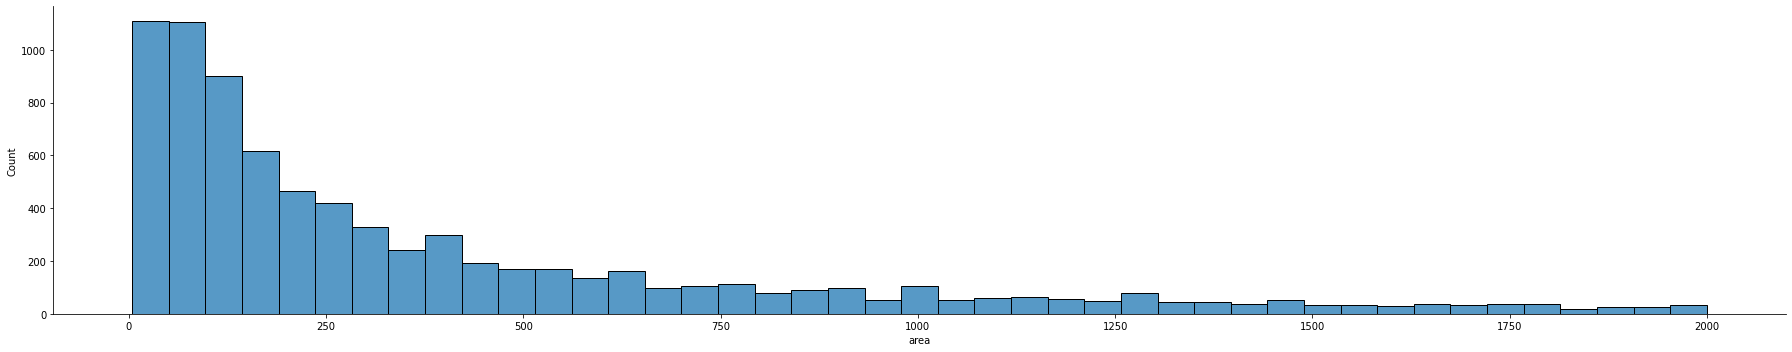

In [ ]:
sns.displot(x=df['area'][df['area'] <=2000], aspect=5)

In [ ]:
def sliding_window(dataframe, stride, windowSize):
    cnt = 0 # Vi tri bat dau, ket thuc cua toa do bbox va so luong image
    image_name = dataframe.loc[:, 'file_name'].values[0]
    print(image_name)

    image = Image.open(image_name)
    id = int(re.findall(r"\d+[.png]", image_name)[0].replace('.', '')) # id cua image
    label = dataframe.loc[:,'label'].values
    bbox = dataframe.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']].values
    for y in range(0, image.size[1], stride):
        for x in range(0, image.size[0], stride):
            begin, end = 0, 0
            img_bbox_info = []
            xmax = x + windowSize[0] # Toa do x max cua slide window
            ymax = y + windowSize[1] # Toa do y max cua slide window
            bbox_cnt = 0 # So luong bbox
            cnt += 1
            for box, lbl in zip(bbox, label):
                name_crop = f"{id}.{cnt}"
                # bbox nam trong slide window
                if (box[0] >= x and box[2] <= xmax) and (box[1] >= y and box[3] <= ymax):
                    bbox_cnt += 1
                    end+=1
                    # Tính tọa độ bounding box mới trong size ảnh (160, 160)
                    xxb_min = box[0] - x
                    yyb_min = box[1] - y
                    xxb_max = box[2] - x
                    yyb_max = box[3] - y
                    img_bbox_info.append([id, xxb_min, yyb_min, xxb_max, yyb_max, idx2sign[lbl], lbl])
                else:
                  # Slide window khong chua bbox
                    img_crop_0bbox = image.crop((x, y, xmax, ymax))
                    img_crop_0bbox.save(f"drive/MyDrive/TrafficSign/data/za_traffic_2020/train_crop/images2/{name_crop}_0.png")
                    
            if bbox_cnt != 0:
                name_crop += "_" + str(bbox_cnt)
                path_crop = f"{name_crop}.png"
                
                # Them duong dan cua image duoc cat tu slide window
                while begin < end:
                  img_bbox_info[begin].insert(0, path_crop)
                  begin+=1

                # print(img_bbox_info)
                # Cắt ảnh có chứa bounding box theo cửa sổ trượt 160x160
                img_crop = image.crop((x, y, xmax, ymax))
                img_crop.save("drive/MyDrive/TrafficSign/data/za_traffic_2020/train_crop/images2/"+path_crop)

                txt_path = f"/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/train_crop/labels2/{name_crop}.txt"
                df_img = pd.DataFrame(data=img_bbox_info, columns=None)
                df_img.to_csv(txt_path, sep=" ", header=False, index=False)

In [ ]:
df['file_name'].unique()[1555]

'drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5252.png'

In [ ]:
!mkdir drive/MyDrive/TrafficSign/data/za_traffic_2020/train_crop/labels2/

In [ ]:
crop_info = []
for uniq in df['file_name'].unique()[1555:]:
  idx = df[df['file_name'] == uniq].index
  sliding_window(df.loc[idx,:], stride=40, windowSize=(160,160))

drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5252.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5255.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5257.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5258.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5259.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5261.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5262.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5263.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5264.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5265.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5267.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5269.png
drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images/5270.png

KeyboardInterrupt: ignored